In [1]:
import pandas as pd
import numpy as np
import statistics 
import random

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 5)

#Loading the table "C1 - t1.xlsx containing tabular log behavioral data on LMS of COURSE 1 at SOU
df = pd.read_excel('C1 - t1.xlsx')
df
#There are 8 columns (in order): 
#column #1: USER ID, 
#column #2: activity type, 
#column #3: activity name, 
#column #4: required time spent on the activity (seconds), 
#column #5: corresponding chapter,
#column #6: expected time spent on the chapter (seconds), 
#column #7: visit time (datetime), 
#column #8: time spent on the activity (seconds).

user = df['USER ID'].unique()
user = list(user)
print(len(user))

#There are two learners dropping out.
user.remove(24632) 
user.remove(24702) 
print(len(user))
#Total number of students: 52

54
52


In [2]:
#For the purpose of feature engineering on noncognitive abilities, I created a new column
#which is time exceeing the corresponding required time: column #8 - column #4 = column #9
column_8 = df.reindex(columns=['访问时长(seconds)'])
column_8 = column_8.values
column_4 = df.reindex(columns=['活动要求学习时间(seconds)'])
column_4 = column_4.values

column_9 = column_8 - column_4
df['高过门槛时长'] = column_9


#Dividing all activieis into 3 arrays according to their types (i.e. video, document, quiz),
#which are c4, c5, c6 respectively.
#Creating another 3 arrays about their corresponding required time spent,  
#which are c1, c2, c3 respectively.
c1 = np.array([196, 537, 170, 344, 399, 845, 381, 257, 354, 1027, 716, 676, 1007, 381, 139])
c2 = np.array([5, 5, 9, 20, 42])
c3 = np.array([53, 6, 3, 3, 3, 3, 3, 3, 3, 
               3, 3, 3, 3, 3, 3, 3, 3])

c4 = ['学一学：人工智能应用示例（一）',
    '学一学：人工智能现状——第三次热潮',
    '学一学：人工智能现状：AI版“双手互搏”有多牛？',
    '学一学：人工智能应用示例（二）', 
    '学一学：人工智能的突破与不确定性',
    '学一学：视觉错觉（一）视力之谜',
    '学一学：视觉错觉（二）颜色错觉',
    '学一学：视觉错觉（三）先验错觉',
    '学一学：声音与视听错觉', 
    '学一学：空间错觉  二维',
    '学一学：空间错觉  三维',
    '学一学：语言错觉',
    '学一学：其他错觉',
    '学一学：思考与小结',
    '补充资料：波士顿动力机器人']
c5 = ['延伸阅读：颠倒的视觉', 
    '延伸阅读：看得见的斑点狗',
    '延伸阅读：火星人脸的阴影', 
    '延伸阅读：听觉错觉与语音、歌唱的智能分析', 
    '想一想：课程回顾']
c6 = ['课程前测', 
    '解释型AI的决策应用调查表', 
    '第一讲 学习体验问卷',
    '第二讲 学习体验问卷',
    '第三讲 学习体验问卷',
    '第四讲 学习体验问卷',
    '第五讲 学习体验问卷',
    '第六讲 学习体验问卷',
    '第七讲 学习体验问卷',
    '第八讲 学习体验问卷',
    '第九讲 学习体验问卷',
    '第十讲 学习体验问卷',
    '第十一讲 学习体验问卷',
    '第十二讲 学习体验问卷',
    '第十三讲 学习体验问卷',
    '第十四讲 学习体验问卷',
    '课程整体回顾问卷']

#Data preprocessing on tabular log behavioral data on LMS of COURSE 1 is done.

In [3]:
#Loading the other table "C1 - t2.xlsx" containing tabular formative assessment data
rf = pd.read_excel('C1 - t2.xlsx')
rf.set_index('USER ID', inplace=True)

#Remove learners who dropped out.
rf = rf.reindex(user)

rf
#There are 6 columns (in order): 
#column #1: USER ID, 
#column #2: percentage of course activities the learner finished, 
#column #3: time spent on the course, 
#column #4: visits, 
#column #5: Percentile according to grade of the final exam,
#column #6: grade of the final exam, 

,完成进度,累计时间(hours),学习次数,Percentile,结业考试成绩
USER ID,,,,,
1625,1.00,9.68,70,0.981,27
24539,0.38,5.44,36,0.907,0
...,...,...,...,...,...
24777,1.00,2.94,61,0.556,6
24776,1.00,3.02,61,0.574,9


In [4]:
import scipy.stats as ss

#Getting individual learner data in a dictionary
#user ID as a key, other corresponding behavioral data as values
USER_ID = {}
for i in user:
     USER_ID[i] = df.loc[df['USER ID'] == i]

#Creating another dictionary that will contain the transformed individual learner data
# which are individual's 26 metrics of 6 noncognitive abilities
USER_ID2 = {}


In [5]:
#Now I am going to conduct feature engineering on the 26 metrics of the 6 noncognitive abilities.
duplicate = {'访问时长(seconds)':'sum', '高过门槛时长':'sum'}  #Will be used for data preprocessing in the for loop

for k, i in enumerate(user): 
    USER_ID2["LEARNER{0}".format(i)] = []

    #Setting activity name as index
    USER_ID[i].reset_index(inplace=True)
    USER_ID[i].set_index('活动名称', inplace=True)
    
    #Getting total time spent on and total of time exceeding in each activity for individual learner
    USER_ID[i] = USER_ID[i].groupby('活动名称').agg(duplicate).reindex(columns=['访问时长(seconds)', '高过门槛时长'])

    #Getting total time spent on each "video" activity for individual learner 
    Time_V = USER_ID[i].reindex(c4, columns =['访问时长(seconds)']).values
    Time_V = list(np.nan_to_num(Time_V).flatten())
    
    #Getting total time spent on each "document" activity for individual learner 
    Time_T = USER_ID[i].reindex(c5, columns =['访问时长(seconds)']).values
    Time_T = list(np.nan_to_num(Time_T).flatten())

    #Getting total time spent on each "quiz" activity for individual learner 
    Time_H = USER_ID[i].reindex(c6, columns =['访问时长(seconds)']).values
    Time_H = list(np.nan_to_num(Time_H).flatten())
    
    #All right! the data preprocessing is done! It's time for feature engineering on the 26 metrics!  
    
    #The 5 metrics of Self-control: 
    Self_control1 = Time_V[9]    #Time spent on the longest "video" activity
    Self_control2 = Time_T[4]    #Time spent on the longest "document" activity
    Self_control3 = Time_H[0]    #Time spent on the "quiz" with the longest required time

    Self_control4 = USER_ID[i].reindex(columns =['访问时长(seconds)']).values 
    Self_control4 = np.nan_to_num(Self_control4)
    Self_control4 = Self_control4.max()    #The longest time spent on a single activity visit (not accumulated)

    Self_control5 = USER_ID[i].reindex(columns = ['访问时长(seconds)']).values    
    Self_control5 = np.nan_to_num(Self_control5)
    Self_control5 = Self_control5.sum() 
    LOGIN = rf.iloc[k, 2]    #Finding the totoal visits in the rf table
    Self_control5 = Self_control5 / LOGIN    #Average time spent per login

    #The 3 metrics of Enagement:
    Engagement1 = USER_ID[i].reindex(columns =['访问时长(seconds)'])    
    Engagement1 = np.nan_to_num(Engagement1).sum()    #Total time spent on the course
    
    Engagement2 = LOGIN    #Total visits
    Engagement3 = rf.iloc[k, 4]    #grade of the final exam (found in the rf table)

    #The 3 metrics of Meta-cognitive Self-regulation:
    Metacognitive_Self_regulation1 = Time_V[13]    #Time spent on the wrap-up "video" activity
    Metacognitive_Self_regulation2 = Time_T[4]    #Time spent on the wrap-up "document" activity
    Metacognitive_Self_regulation3 = Time_H[16]    #Time spent on the wrap-up "quiz" activity   
    
    #The 3 metrics of Motivation:
    Motivation1 = USER_ID[i].reindex(columns =['高过门槛时长']).values
    Motivation1 = np.nan_to_num(Motivation1).sum()    #The total amount of time exceeding required time

    Motivation2 = np.array(USER_ID[i].reindex(['延伸阅读：人工智能的历史现状与未来（选修）', '延伸阅读：我思故我在？（选修）'], 
                                              columns = ['访问时长(seconds)']).values).flatten()
    Motivation2 = np.nan_to_num(Motivation2).sum()    #The total amount of time spent on elective activities

    Motivation3 = rf.iloc[k, 0]    #percentage of course activities the learner finished (found in the rf table)
    

    #Now each learner is represented as a list containing the scores of the metrics in the USER_ID2 dictionary 
    #Time_V, Time_T, Time_H will be used for engineering "grit" metrics
    USER_ID2["LEARNER{0}".format(i)].append(Time_V + Time_T + Time_H + 
                                             [Self_control1,
                                             Self_control2,
                                             Self_control3,
                                             Self_control4,
                                             Self_control5,
                                             Engagement1,
                                             Engagement2,
                                             Engagement3,
                                             Metacognitive_Self_regulation1,
                                             Metacognitive_Self_regulation2,
                                             Metacognitive_Self_regulation3,
                                             Motivation1,
                                             Motivation2,
                                             Motivation3])


In [6]:
#Pairing the learner's user ID (string) and his/her scores of the metrics (list) as a tuple
USER_ID2.items()

dict_items([('LEARNER24587', [[167, 308, 131, 187, 188, 427, 260, 189, 212, 563, 438, 368, 647, 339, 83, 128, 124, 134, 137, 156, 189, 37, 21, 46, 29, 23, 24, 24, 31, 21, 30, 26, 22, 20, 35, 31, 28, 563, 156, 189, 647, 94.73913043478261, 6537, 69, 6, 339, 156, 28, 1677, 614, 1.0]]), ('LEARNER24776', [[262, 481, 264, 1194, 858, 888, 363, 502, 293, 761, 529, 530, 1084, 381, 189, 132, 173, 134, 133, 130, 489, 120, 16, 19, 129, 18, 41, 35, 32, 78, 38, 51, 28, 24, 27, 42, 27, 761, 130, 489, 1194, 178.45901639344262, 10886, 61, 9, 381, 130, 27, 6026, 199, 1.0]]), ('LEARNER24778', [[323, 467, 264, 1217, 870, 876, 362, 512, 294, 769, 534, 541, 1073, 381, 81, 131, 174, 132, 134, 129, 711, 120, 58, 19, 128, 19, 29, 35, 20, 77, 37, 43, 38, 31, 28, 54, 27, 769, 129, 711, 1217, 183.01639344262296, 11164, 61, 15, 381, 129, 27, 6304, 234, 1.0]]), ('LEARNER24586', [[231, 1151, 224, 386, 420, 856, 389, 276, 377, 1142, 829, 688, 593, 309, 144, 167, 156, 220, 124, 209, 304, 25, 40, 12, 14, 19, 8, 8, 15, 

In [7]:
#Metrics of "grit" and "self-perception" have not been engineered yet
#Now I am going to engineer metrics of the two noncognitive abilities and create a data frame (table) 
#with learners as rows and the 26 metrics as columns

#Transforming USER_ID2 to a data frame with learners as rows 
column_names = c4 + c5 + c6 + [ 
                'SC1', 
                'SC2', 
                'SC3', 
                'SC4', 
                'SC5', 
                'E1', 
                'E2', 
                'E3', 
                'MSR1', 
                'MSR2', 
                'MSR3',
                'M1', 
                'M2', 
                'M3']

df_Data_Point = pd.DataFrame(columns = column_names)

for i in user:
    a_series = pd.Series(USER_ID2['LEARNER' + str(i)][0], index = df_Data_Point.columns)    #as a column
    df_Data_Point = df_Data_Point.append(a_series, ignore_index=True)    #as a row

df_Data_Point.index = user
df_Data_Point.head()

,学一学：人工智能应用示例（一）,学一学：人工智能现状——第三次热潮,学一学：人工智能现状：AI版“双手互搏”有多牛？,学一学：人工智能应用示例（二）,学一学：人工智能的突破与不确定性,学一学：视觉错觉（一）视力之谜,学一学：视觉错觉（二）颜色错觉,学一学：视觉错觉（三）先验错觉,学一学：声音与视听错觉,学一学：空间错觉 二维,学一学：空间错觉 三维,学一学：语言错觉,学一学：其他错觉,学一学：思考与小结,补充资料：波士顿动力机器人,延伸阅读：颠倒的视觉,延伸阅读：看得见的斑点狗,延伸阅读：火星人脸的阴影,延伸阅读：听觉错觉与语音、歌唱的智能分析,想一想：课程回顾,课程前测,解释型AI的决策应用调查表,第一讲 学习体验问卷,第二讲 学习体验问卷,第三讲 学习体验问卷,...,第五讲 学习体验问卷,第六讲 学习体验问卷,第七讲 学习体验问卷,第八讲 学习体验问卷,第九讲 学习体验问卷,第十讲 学习体验问卷,第十一讲 学习体验问卷,第十二讲 学习体验问卷,第十三讲 学习体验问卷,第十四讲 学习体验问卷,课程整体回顾问卷,SC1,SC2,SC3,SC4,SC5,E1,E2,E3,MSR1,MSR2,MSR3,M1,M2,M3
1625,367.0,568.0,186.0,1395.0,1550.0,2951.0,2714.0,1559.0,371.0,1190.0,2771.0,3401.0,1509.0,426.0,153.0,347.0,184.0,1393.0,135.0,729.0,835.0,113.0,29.0,20.0,8.0,...,16.0,15.0,11.0,9.0,12.0,16.0,12.0,9.0,9.0,10.0,15.0,1190.0,729.0,835.0,9393.0,497.757143,34843.0,70.0,27.0,426.0,729.0,15.0,29983.0,9723.0,1.00
24539,5221.0,909.0,431.0,911.0,704.0,1201.0,849.0,355.0,430.0,890.0,554.0,666.0,828.0,438.0,0.0,0.0,0.0,0.0,0.0,1816.0,2786.0,609.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,890.0,1816.0,2786.0,5221.0,544.388889,19598.0,36.0,0.0,438.0,1816.0,0.0,15518.0,0.0,0.38
24581,214.0,562.0,179.0,220.0,360.0,855.0,255.0,209.0,237.0,617.0,536.0,396.0,649.0,3.0,144.0,330.0,137.0,685.0,139.0,124.0,273.0,22.0,7.0,12.0,16.0,...,10.0,21.0,15.0,25.0,11.0,15.0,12.0,9.0,9.0,10.0,11.0,617.0,124.0,273.0,855.0,121.161290,7512.0,62.0,30.0,3.0,124.0,11.0,2772.0,138.0,0.97
24586,231.0,1151.0,224.0,386.0,420.0,856.0,389.0,276.0,377.0,1142.0,829.0,688.0,593.0,309.0,144.0,167.0,156.0,220.0,124.0,209.0,304.0,25.0,40.0,12.0,14.0,...,8.0,8.0,15.0,14.0,10.0,14.0,36.0,9.0,11.0,9.0,20.0,1142.0,209.0,304.0,1151.0,149.907692,9744.0,65.0,27.0,309.0,209.0,20.0,4884.0,233.0,1.00
24585,235.0,560.0,207.0,363.0,422.0,851.0,385.0,259.0,359.0,1079.0,760.0,799.0,562.0,253.0,173.0,133.0,145.0,186.0,153.0,131.0,121.0,70.0,66.0,40.0,13.0,...,14.0,22.0,14.0,9.0,20.0,20.0,20.0,12.0,10.0,20.0,13.0,1079.0,131.0,121.0,1079.0,114.784810,9068.0,79.0,18.0,253.0,131.0,13.0,4208.0,305.0,1.00


In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()    # Scaling to 0~1
df_Learners = scaler.fit_transform(df_Data_Point)    #axis = 0; scaleing on each column
# Now df_Learners is a 52 x 51 matrix; each array represents a learner

# Making arrays "rows of data frame"
df_Learners = pd.DataFrame(df_Learners, index = df_Data_Point.index, 
                                          columns = column_names)

df_Learners.head()

,学一学：人工智能应用示例（一）,学一学：人工智能现状——第三次热潮,学一学：人工智能现状：AI版“双手互搏”有多牛？,学一学：人工智能应用示例（二）,学一学：人工智能的突破与不确定性,学一学：视觉错觉（一）视力之谜,学一学：视觉错觉（二）颜色错觉,学一学：视觉错觉（三）先验错觉,学一学：声音与视听错觉,学一学：空间错觉 二维,学一学：空间错觉 三维,学一学：语言错觉,学一学：其他错觉,学一学：思考与小结,补充资料：波士顿动力机器人,延伸阅读：颠倒的视觉,延伸阅读：看得见的斑点狗,延伸阅读：火星人脸的阴影,延伸阅读：听觉错觉与语音、歌唱的智能分析,想一想：课程回顾,课程前测,解释型AI的决策应用调查表,第一讲 学习体验问卷,第二讲 学习体验问卷,第三讲 学习体验问卷,...,第五讲 学习体验问卷,第六讲 学习体验问卷,第七讲 学习体验问卷,第八讲 学习体验问卷,第九讲 学习体验问卷,第十讲 学习体验问卷,第十一讲 学习体验问卷,第十二讲 学习体验问卷,第十三讲 学习体验问卷,第十四讲 学习体验问卷,课程整体回顾问卷,SC1,SC2,SC3,SC4,SC5,E1,E2,E3,MSR1,MSR2,MSR3,M1,M2,M3
1625,0.069402,0.493484,0.170486,0.838341,0.362057,1.000000,0.398826,0.590097,0.218879,0.515375,0.366389,1.000000,0.852542,0.073133,0.213986,0.046646,0.211009,1.000000,0.105551,0.401432,0.279276,0.041839,0.073980,0.277778,0.027119,...,0.129032,0.283019,0.068323,0.004178,0.046154,0.094675,0.196721,0.067164,0.064748,0.084034,0.217391,0.515375,0.401432,0.279276,1.000000,0.724610,1.000000,0.4250,0.9,0.073133,0.401432,0.217391,1.000000,1.000000,1.000000
24539,1.000000,0.789748,0.395050,0.547476,0.163419,0.406981,0.110751,0.101461,0.253687,0.385448,0.073251,0.195825,0.467797,0.075193,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.269885,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.385448,1.000000,1.000000,0.528108,0.802106,0.496997,0.0000,0.0,0.075193,1.000000,0.000000,0.522733,0.000000,0.000000
24581,0.040069,0.488271,0.164070,0.132212,0.082649,0.289732,0.018999,0.042208,0.139823,0.267215,0.070871,0.116436,0.366667,0.000515,0.201399,0.044361,0.157110,0.491744,0.108679,0.068282,0.071666,0.000000,0.017857,0.166667,0.054237,...,0.080645,0.396226,0.093168,0.011606,0.042308,0.088757,0.196721,0.067164,0.064748,0.084034,0.159420,0.267215,0.068282,0.071666,0.034272,0.098751,0.098225,0.3250,1.0,0.000515,0.068282,0.159420,0.102184,0.014193,0.951613
24586,0.043328,1.000000,0.205316,0.231971,0.096736,0.290071,0.039697,0.069399,0.222419,0.494586,0.109613,0.202293,0.335028,0.053047,0.201399,0.022449,0.178899,0.157933,0.096951,0.115088,0.083118,0.001379,0.102041,0.166667,0.047458,...,0.064516,0.150943,0.093168,0.006500,0.038462,0.082840,0.590164,0.067164,0.079137,0.075630,0.289855,0.494586,0.115088,0.083118,0.067753,0.146524,0.171869,0.3625,0.9,0.053047,0.115088,0.289855,0.171869,0.023964,1.000000
24585,0.044095,0.486533,0.189734,0.218149,0.097206,0.288377,0.039079,0.062500,0.211799,0.467302,0.100489,0.234931,0.317514,0.043433,0.241958,0.017879,0.166284,0.133525,0.119625,0.072137,0.015515,0.022069,0.168367,0.555556,0.044068,...,0.112903,0.415094,0.086957,0.004178,0.076923,0.118343,0.327869,0.089552,0.071942,0.168067,0.188406,0.467302,0.072137,0.015515,0.059609,0.088154,0.149564,0.5375,0.6,0.043433,0.072137,0.188406,0.149564,0.031369,1.000000


In [9]:
#Engineering metrics of "grit" and "self-perception" 
#and adding them into the df_Learners data frame above

#The 6 metrics of Grit: 
df_Learners['G1'] = np.mean(df_Learners.loc[:, c4], axis = 1)    #"mean" of min-max normalized time spent on each video activity
df_Learners['G2'] = np.mean(df_Learners.loc[:, c5], axis = 1)    #"mean" of min-max normalized time spent on each document activity 
df_Learners['G3'] = np.mean(df_Learners.loc[:, c6], axis = 1)    #"mean" of min-max normalized time spent on each quiz activity 
df_Learners['G4'] = 1 / np.std(df_Learners.loc[:, c4], axis = 1)    #reciprocal of "SD" of min-max normalized time spent on each video activity
df_Learners['G5'] = 1 / np.std(df_Learners.loc[:, c5], axis = 1)    #reciprocal of "SD" of min-max normalized time spent on each document activity
df_Learners['G6'] = 1 / np.std(df_Learners.loc[:, c6], axis = 1)    #reciprocal of "SD" of min-max normalized time spent on each quiz activity

#The 6 metrics of Self-pereption: 
#squared reciprocal of the difference between "average" time spent on video activity (min-max normalized) in the 1st and 2nd half of the course
df_Learners['SP1'] = 1 / (np.mean(df_Learners.iloc[:, :8], axis = 1) - np.mean(df_Learners.iloc[:, 8:15], axis = 1))**2
#squared reciprocal of the difference between "average" time spent on document activity (min-max normalized) in the 1st and 2nd half of the course
df_Learners['SP2'] = 1 / (np.mean(df_Learners.iloc[:, 15:18], axis = 1) - np.mean(df_Learners.iloc[:, 18:20], axis = 1))**2
#squared reciprocal of the difference between "average" time spent on quiz activity (min-max normalized) in the 1st and 2nd half of the course
df_Learners['SP3'] = 1 / (np.mean(df_Learners.iloc[:, 20:28], axis = 1) - np.mean(df_Learners.iloc[:, 28:37], axis = 1))**2
#squared reciprocal of the difference between "SD" of time spent on video activity (min-max normalized) in the 1st and 2nd half of the course
df_Learners['SP4'] = 1 / (np.std(df_Learners.iloc[:, :8], axis = 1) - np.std(df_Learners.iloc[:, 8:15], axis = 1))**2
#squared reciprocal of the difference between "SD" of time spent on document activity (min-max normalized) in the 1st and 2nd half of the course
df_Learners['SP5'] = 1 / (np.std(df_Learners.iloc[:, 15:18], axis = 1) - np.std(df_Learners.iloc[:, 18:20], axis = 1))**2
#squared reciprocal of the difference between "SD" of time spent on quiz activity (min-max normalized) in the 1st and 2nd half of the course
df_Learners['SP6'] = 1 / (np.std(df_Learners.iloc[:, 20:28], axis = 1) - np.std(df_Learners.iloc[:, 28:37], axis = 1))**2

In [10]:
#Scaling grit and self-perception to 0~1
G_SP = ['G1','G2','G3','G4','G5','G6','SP1','SP2','SP3','SP4','SP5','SP6']
df_Learners[G_SP] = scaler.fit_transform(df_Learners[G_SP])
df_Learners_2 = df_Learners.drop(c4, axis =1)
df_Learners_2 = df_Learners_2.drop(c5, axis = 1)
df_Learners_2 = df_Learners_2.drop(c6, axis = 1)
df_Learners_2.describe()

,SC1,SC2,SC3,SC4,SC5,E1,E2,E3,MSR1,MSR2,MSR3,M1,M2,M3,G1,G2,G3,G4,G5,G6,SP1,SP2,SP3,SP4,SP5,SP6
count,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000,52.000000,52.000000,52.000000,52.00000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000
mean,0.401956,0.117185,0.207667,0.140260,0.226729,0.238243,0.330769,0.500,0.079617,0.117185,0.338907,0.24521,0.045343,0.941687,0.419372,0.194816,0.409422,0.213166,0.337508,0.247066,0.020604,0.027395,0.071862,0.041579,0.062738,0.050240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75%,0.577090,0.085490,0.313447,0.172831,0.347780,0.378893,0.353125,0.725,0.072661,0.085490,0.413043,0.39139,0.024221,1.000000,0.661534,0.239536,0.603177,0.373015,0.499076,0.284002,0.000312,0.001739,0.014815,0.000204,0.030754,0.006952
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
#Checking for NaN and positive or negative infinity under the entire data frame
print(df_Learners_2.isnull().sum().sum())
print(np.isinf(df_Learners_2).sum().sum())

0
0


In [12]:
#Coy df_Learners_2 (just in case)
df_Learners_3 = df_Learners_2[:]    # still a dataframe

In [13]:
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,10))
e = df_Learners_3.corr()
sns.heatmap(e, cmap="YlGnBu")


In [14]:
from __future__ import print_function
import sys
import numpy
numpy.set_printoptions(linewidth=1000)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#Coducting PCA (where I set 5 principal components initially).
n=5
pca = PCA(n_components=n, random_state= 88)
pct = pca.fit_transform(df_Learners_3)

#Appending the 5 principle components (PCs) to the df_Learners_3 data frame
for i in range(n):
    df_Learners_3['PC' + str(i + 1)] = pct[:, i]

display(df_Learners_3.head())

C:\Users\lawre\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,SC1,SC2,SC3,SC4,SC5,E1,E2,E3,MSR1,MSR2,MSR3,M1,M2,M3,G1,G2,G3,G4,G5,G6,SP1,SP2,SP3,SP4,SP5,SP6,PC1,PC2,PC3,PC4,PC5
1625,0.515375,0.401432,0.279276,1.000000,0.724610,1.000000,0.4250,0.9,0.073133,0.401432,0.217391,1.000000,1.000000,1.000000,0.974972,0.657777,0.137525,0.038550,0.011153,0.541322,0.000308,0.000011,0.001017,6.905206e-05,0.000440,0.005907,1.588140,0.927795,0.040503,0.090463,-0.154080
24539,0.385448,1.000000,1.000000,0.528108,0.802106,0.496997,0.0000,0.0,0.075193,1.000000,0.000000,0.522733,0.000000,0.000000,0.633783,0.321567,0.000000,0.059277,0.000615,0.104407,0.000000,0.000000,0.000091,7.871712e-07,0.000000,0.000000,1.205244,-0.058672,1.326754,-0.233334,0.970564
24581,0.267215,0.068282,0.071666,0.034272,0.098751,0.098225,0.3250,1.0,0.000515,0.068282,0.159420,0.102184,0.014193,0.951613,0.238542,0.264483,0.072312,0.258405,0.096960,0.543733,0.002989,0.000015,0.009716,3.982688e-05,0.001365,0.002228,-0.266288,0.638704,-0.083443,-0.078691,0.119662
24586,0.494586,0.115088,0.083118,0.067753,0.146524,0.171869,0.3625,0.9,0.053047,0.115088,0.289855,0.171869,0.023964,1.000000,0.420833,0.133076,0.139347,0.090088,0.423021,0.314895,0.000928,0.001803,0.000915,3.085582e-07,0.012063,0.000553,-0.130981,0.366206,-0.232554,0.103247,0.144013
24585,0.467302,0.072137,0.015515,0.059609,0.088154,0.149564,0.5375,0.6,0.043433,0.072137,0.188406,0.149564,0.031369,1.000000,0.335136,0.105872,0.257706,0.243727,0.448091,0.276303,0.000080,0.003395,0.000617,2.195861e-04,0.027734,0.000961,-0.278195,0.173742,-0.078068,0.122864,0.014553


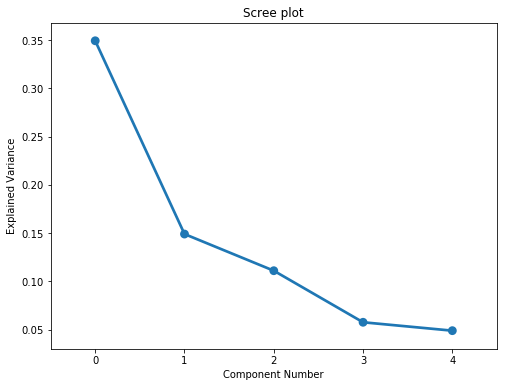

In [15]:
#Ploting a scree plot (for the purpose of deciding the number of PC)
ind = np.arange(n)
(fig, ax) = plt.subplots(figsize=(8, 6))
sns.pointplot(x=ind, y=pca.explained_variance_ratio_)
ax.set_title('Scree plot')
ax.set_xlabel('Component Number')
ax.set_ylabel('Explained Variance')
plt.show()

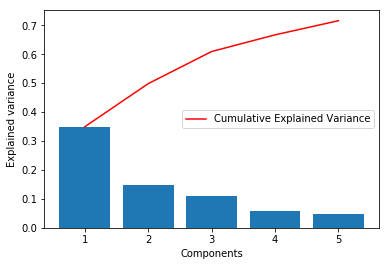

In [16]:
#Checking for eigenvalues (i.e. variance on each PC)
check_eigenValues_pca = pca.explained_variance_ratio_    #array of 5 values

plt.bar(range(1, len(check_eigenValues_pca)+1), check_eigenValues_pca)
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(check_eigenValues_pca)+1),
         np.cumsum(check_eigenValues_pca),
         c='red',
         label="Cumulative Explained Variance")
plt.legend(loc='center right')

In [17]:
#Checking for 26 metrics' loadings on each PC (i.e. checking for the 5 eigenvectors) 
check_loadings_pca = pca.components_    #matrix of 5 X 26

#Dropping the 5 columns of PCs
df_Learners_3_drop_pc = df_Learners_3.reindex(columns=df_Learners_2.columns)

#Creating a table with 5 PCs as columns and metrics as rows (values in the table are loadings)
num_pc = 5
check_pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
check_loadings_df = pd.DataFrame.from_dict(dict(zip(check_pc_list, check_loadings_pca)))
check_loadings_df['variable'] = df_Learners_3_drop_pc.columns.values
check_loadings_df = check_loadings_df.set_index('variable')
check_loadings_df

,PC1,PC2,PC3,PC4,PC5
variable,,,,,
SC1,0.221381,-0.120373,-0.170108,0.274756,-0.026123
SC2,0.108279,0.084184,0.197527,-0.116615,0.359868
...,...,...,...,...,...
SP5,-0.046353,0.011700,-0.088634,0.178550,0.175850
SP6,-0.062289,0.055782,0.004939,-0.219084,-0.109086


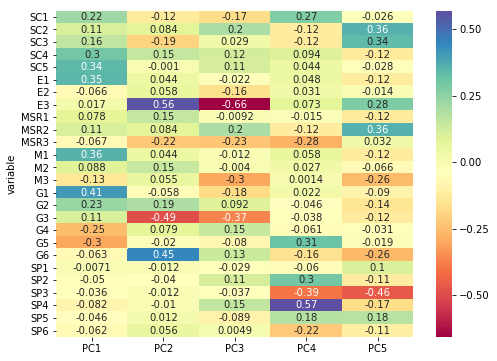

In [18]:
#Visualizing the table above with a heatmap
fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.heatmap(check_loadings_df, annot=True, cmap='Spectral')
plt.show()

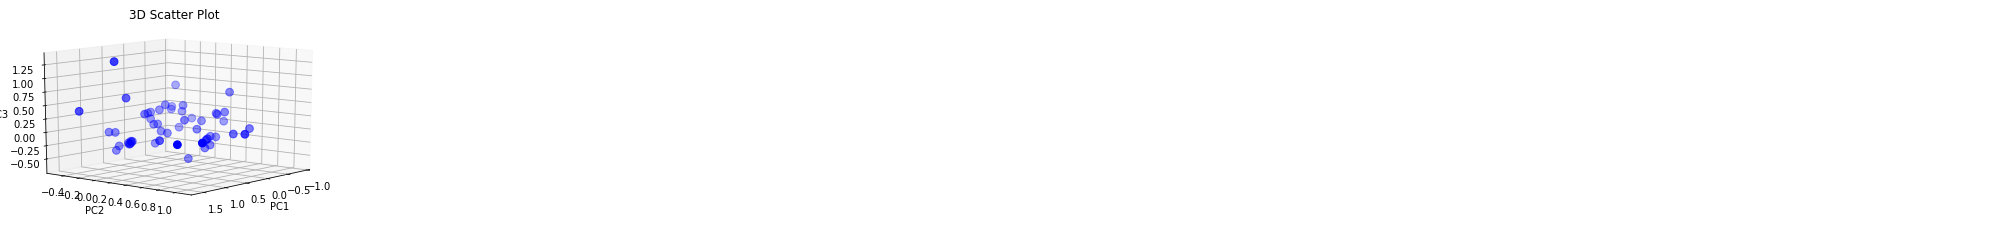

In [19]:
#As a result, the number of PCs is decided to be 3
#Projecting data onto the 3-D space consisting of the 3 PCs
from mpl_toolkits.mplot3d import Axes3D

x = df_Learners_3['PC1'].astype('float32')
y = df_Learners_3['PC2'].astype('float32')
z = df_Learners_3['PC3'].astype('float32')


fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_title('3D Scatter Plot')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

ax.view_init(elev=12, azim=40)              # elevation and angle
ax.dist=10                                 # distance
ax.scatter(
       x, y, z,  # data
       c='blue',                            # marker colour
       #marker='o',                   # marker shape
       s=60,                         # marker size
       cmap='viridis'
       )

plt.show()

In [20]:
#Since selecting the first 3 PCs, droping the other 2 PCs (i.e. PC4 & PC5) out of the data frame
df_Learners_3 = df_Learners_3.drop(columns =['PC4', 'PC5']) 

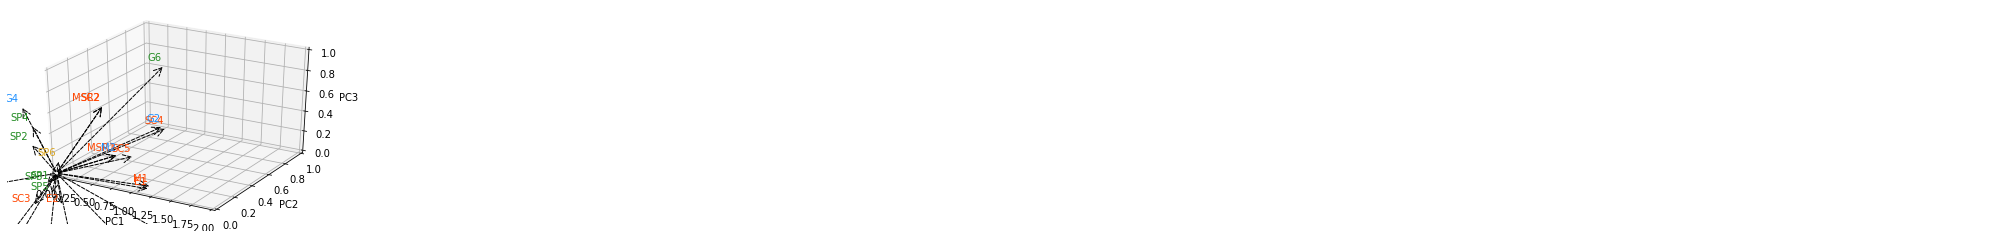

In [21]:
# Ploting a variable factor map (i.e. vectors of 26 metrics in the space consisting of the 3 PCs)
from mpl_toolkits.mplot3d import axes3d
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.text import Annotation


class Annotation3D(Annotation):
    '''Annotate the point xyz with text s'''

    def __init__(self, s, xyz, *args, **kwargs):
        Annotation.__init__(self,s, xy=(0,0), *args, **kwargs)
        self._verts3d = xyz        

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.xy=(xs,ys)
        Annotation.draw(self, renderer)

        
def annotate3D(ax, s, *args, **kwargs):
    '''add anotation text s to to Axes3d ax'''
    tag = Annotation3D(s, *args, **kwargs)
    ax.add_artist(tag)

    
class Arrow3D(FancyArrowPatch):
    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._xyz = (x,y,z)
        self._dxdydz = (dx,dy,dz)

    def draw(self, renderer):
        x1,y1,z1 = self._xyz
        dx,dy,dz = self._dxdydz
        x2,y2,z2 = (x1+dx,y1+dy,z1+dz)

        xs, ys, zs = proj_transform((x1,x2),(y1,y2),(z1,z2), renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        super().draw(renderer)

def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)

setattr(Axes3D,'arrow3D',_arrow3D)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.set_xlim(0,2)
for i in range(0, len(df_Learners_2.columns)):          # Each PCA's number of features
    ax.arrow3D(0,0,0,
               pca.components_[0, i] * 3, pca.components_[1, i] * 3, pca.components_[2, i] * 3,
               mutation_scale=20,
               arrowstyle="->",
               linestyle='dashed')               
    if i < 12:
        annotate3D(ax, df_Learners_2.columns[i], 
        (pca.components_[0, i] * 3 + 0.001,  pca.components_[1, i] * 3 + 0.001, pca.components_[2, i] * 3 + 0.001), 
        fontsize=10, xytext=(-3,3), textcoords='offset points', color='orangered', ha='right',va='bottom')
    elif i < 19:
        annotate3D(ax, df_Learners_2.columns[i], 
               (pca.components_[0, i] * 3 + 0.001,  pca.components_[1, i] * 3 + 0.001, pca.components_[2, i] * 3 + 0.001), 
               fontsize=10, xytext=(-3,3), textcoords='offset points', color='dodgerblue', ha='right',va='bottom')        
    elif i < 25:
        annotate3D(ax, df_Learners_2.columns[i], 
        (pca.components_[0, i] * 3 + 0.001,  pca.components_[1, i] * 3 + 0.001, pca.components_[2, i] * 3 + 0.001), 
        fontsize=10, xytext=(-3,3), textcoords='offset points', color='forestgreen', ha='right',va='bottom') 
    elif i < 27: 
        annotate3D(ax, df_Learners_2.columns[i], 
        (pca.components_[0, i] * 3 + 0.001,  pca.components_[1, i] * 3 + 0.001, pca.components_[2, i] * 3 + 0.001), 
        fontsize=10, xytext=(-3,3), textcoords='offset points', color='goldenrod', ha='right',va='bottom') 
    elif i < 31: 
        annotate3D(ax, df_Learners_2.columns[i], 
        (pca.components_[0, i] * 3 + 0.001,  pca.components_[1, i] * 3 + 0.001, pca.components_[2, i] * 3 + 0.001), 
        fontsize=10, xytext=(-3,3), textcoords='offset points', color='beige', ha='right',va='bottom')      
    else:  
        annotate3D(ax, df_Learners_2.columns[i], 
        (pca.components_[0, i] * 3 + 0.001,  pca.components_[1, i] * 3 + 0.001, pca.components_[2, i] * 3 + 0.001), 
        fontsize=10, xytext=(-3,3), textcoords='offset points', color='violet', ha='right',va='bottom')  

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')


plt.show()

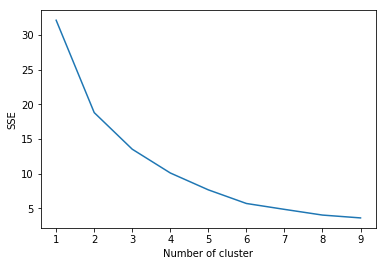

In [22]:
#Creating a table containing 3 PCs
df_Learners_3_3PC = df_Learners_3.iloc[:, -3:]

#Now conducting k-means clustering! 
#First creating a screet plot to decide the hyperparameter "k" (via elbow method)
from sklearn.cluster import KMeans

sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_Learners_3_3PC)
    sse[k] = kmeans.inertia_    # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

C:\Users\lawre\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


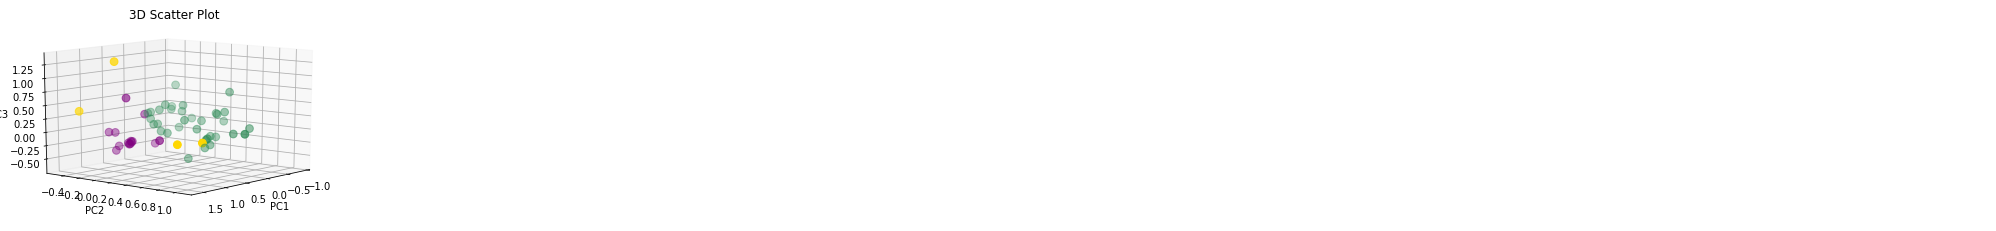

In [23]:
#After deciding k to be 3, visualizing the k-meas clusting result in the space consisting of the 3 PCs

kmeans = KMeans(n_clusters=3)
kmeans.fit(df_Learners_3_3PC)
y_kmeans = kmeans.predict(df_Learners_3_3PC)    # clusters with lables of 0, 1, or 2
df_Learners_3_3PC['cluster'] = y_kmeans.astype('float32')

x = df_Learners_3_3PC['PC1'].astype('float32')
y = df_Learners_3_3PC['PC2'].astype('float32')
z = df_Learners_3_3PC['PC3'].astype('float32')


fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_title('3D Scatter Plot')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

colors = {0:'purple', 1:'seagreen', 2:'gold'}    #0 = purple; 1 = seagreen; 2 = gold
PSG=df_Learners_3_3PC['cluster'].apply(lambda x: colors[x])

ax.view_init(elev=12, azim=40)              # elevation and angle
ax.dist=10                                 # distance
ax.scatter(
       x, y, z,    # data
       c=PSG,    # marker colour
       s=60,    # marker size
       cmap='viridis'
       )

plt.show()

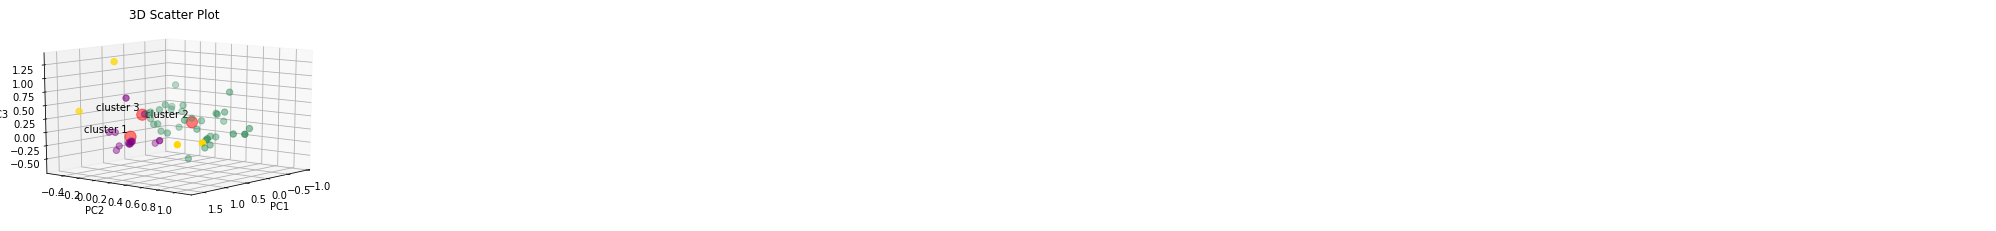

In [24]:
#Centers of the three clusters
centers = kmeans.cluster_centers_    # 0 = cluster 1 (i.e. first array); 1 = cluster 2 (i.e. second array); 2 = cluster 3 (i.e. third array)

#Marking centers
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_title('3D Scatter Plot')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

ax.view_init(elev=12, azim=40)              # elevation and angle
ax.dist=10                                 # distance
ax.scatter(
       x, y, z,    # data
       c=PSG,    # marker colour
       s=40,    # marker size
       cmap='viridis'
       )

ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='red', s=125, alpha=0.5)
n = ['cluster 1', 'cluster 2', 'cluster 3']
for i, txt in enumerate(n):
    annotate3D(ax, txt, centers[i, :], fontsize=10, xytext=(-3,3),
               textcoords='offset points', ha='right',va='bottom')

plt.show()


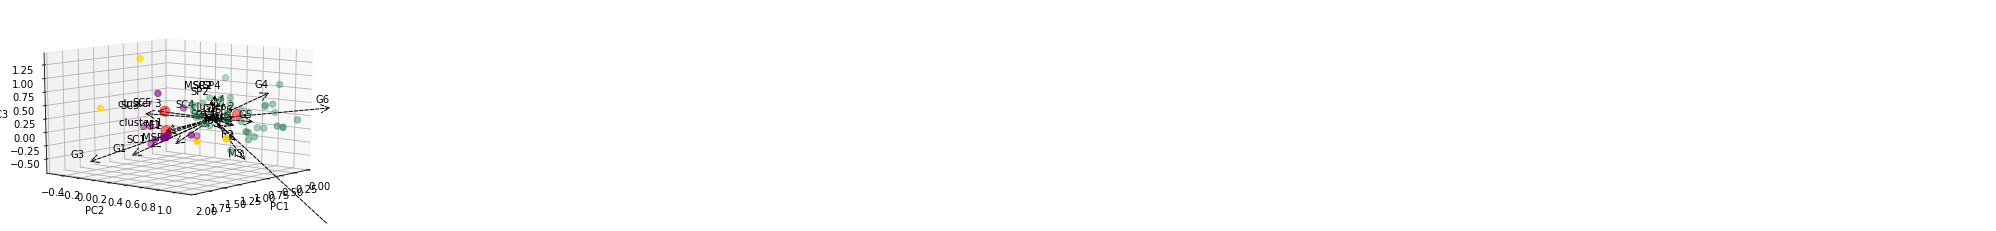

In [25]:
#Now putting the k-means clustering results and centers, the vector map in the space consisting of 3 PCs together!
class Arrow3D(FancyArrowPatch):
    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._xyz = (x,y,z)
        self._dxdydz = (dx,dy,dz)

    def draw(self, renderer):
        x1,y1,z1 = self._xyz
        dx,dy,dz = self._dxdydz
        x2,y2,z2 = (x1+dx,y1+dy,z1+dz)

        xs, ys, zs = proj_transform((x1,x2),(y1,y2),(z1,z2), renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        super().draw(renderer)

def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)

setattr(Axes3D,'arrow3D',_arrow3D)




fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.set_xlim(0,2)
for i in range(0, len(df_Learners_2.columns)):    #number of metrics
    ax.arrow3D(0,0,0,
               pca.components_[0, i] * 3, pca.components_[1, i] * 3, pca.components_[2, i] * 3,    #3 PCs
               mutation_scale=20,
               arrowstyle="->",
               linestyle='dashed')               
    annotate3D(ax, df_Learners_2.columns[i], 
               (pca.components_[0, i] * 3 + 0.001,  pca.components_[1, i] * 3 + 0.001, pca.components_[2, i] * 3 + 0.001), 
               fontsize=10, xytext=(-3,3), textcoords='offset points', ha='right',va='bottom')


ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

ax.view_init(elev=12, azim=40)              # elevation and angle
ax.dist=10                                 # distance
ax.scatter(
       x, y, z,    # data
       c=PSG,    # marker colour
       s=40,    # marker size
       cmap='viridis'
       )

ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='red', s=100, alpha=0.5)
n = ['cluster 1', 'cluster 2', 'cluster 3']
for i, txt in enumerate(n):
    annotate3D(ax, txt, centers[i, :], fontsize=10, xytext=(-3,3),
               textcoords='offset points', ha='right',va='bottom')

plt.show()

In [26]:
#Finally, I am going to plot learner personas according to the results above!

#Creating a new column indicating a cluster a learner belongs to
df_Learners_3['cluster'] = y_kmeans
df_Learners_3.head()    

cluster_1 = df_Learners_3.loc[df_Learners_3['cluster'] == 0]    #data frame of learners belonging to cluster 1
cluster_2 = df_Learners_3.loc[df_Learners_3['cluster'] == 1]    #data frame of learners belonging to cluster 2
cluster_3 = df_Learners_3.loc[df_Learners_3['cluster'] == 2]    #data frame of learners belonging to cluster 3

#Creating a series of a corresponding cluster's mean value of each of the 26 metrics, PC values, and cluster
mean_cluster_1 = cluster_1.mean(axis = 0)    #series
mean_cluster_2 = cluster_2.mean(axis = 0)
mean_cluster_3 = cluster_3.mean(axis = 0)

#Stacking series as a data frame
df_cluster = pd.DataFrame(columns = df_Learners_3.columns)
df_cluster = df_cluster.append(mean_cluster_1, ignore_index=True)
df_cluster = df_cluster.append(mean_cluster_2, ignore_index=True)
df_cluster = df_cluster.append(mean_cluster_3, ignore_index=True)
df_cluster

,SC1,SC2,SC3,SC4,SC5,E1,E2,E3,MSR1,MSR2,MSR3,M1,M2,M3,G1,G2,G3,G4,G5,G6,SP1,SP2,SP3,SP4,SP5,SP6,PC1,PC2,PC3,cluster
0,0.615078,0.104665,0.382448,0.177331,0.354836,0.382888,0.290179,0.500000,0.064390,0.104665,0.383023,0.393069,0.019740,0.925115,0.670463,0.240431,0.685325,0.066363,0.203694,0.097041,0.000396,0.000331,0.045330,0.000147,0.056900,0.020898,0.466338,-0.279976,-0.200525,0.0
1,0.299722,0.087264,0.119777,0.050317,0.105661,0.115227,0.362500,0.505882,0.061479,0.087264,0.346121,0.119594,0.029155,0.984345,0.262683,0.125059,0.318976,0.295150,0.431729,0.298017,0.031338,0.041761,0.091080,0.063525,0.072504,0.065843,-0.356922,0.068143,0.028675,1.0
2,0.525011,0.415336,0.343000,0.775025,0.807431,0.777625,0.203125,0.450000,0.287082,0.415336,0.123188,0.795442,0.272550,0.637097,0.872406,0.628102,0.212550,0.030110,0.004976,0.339066,0.000085,0.000003,0.001375,0.000059,0.000160,0.020310,1.401657,0.400704,0.458098,2.0


In [27]:
list_mean_cluster_1 = mean_cluster_1.tolist()    #from series to list
list_mean_cluster_2 = mean_cluster_2.tolist()
list_mean_cluster_3 = mean_cluster_3.tolist()

#Calculating each cluster (persona)'s 6 non-cognitive abilities by calculating the mean of corresponding metrics
SC = []
E = []
MSR = []
M = []
G = []
SP = []

for i in range(3):
    SC_metrics = eval('list_mean_cluster_'+str(i+1))[:5]
    SC.append(statistics.mean(SC_metrics))
    E_metrics = eval('list_mean_cluster_'+str(i+1))[5:8]
    E.append(statistics.mean(E_metrics))
    MSR_metrics = eval('list_mean_cluster_'+str(i+1))[8:11]
    MSR.append(statistics.mean(MSR_metrics))
    M_metrics = eval('list_mean_cluster_'+str(i+1))[11:14]
    M.append(statistics.mean(M_metrics))
    G_metrics = eval('list_mean_cluster_'+str(i+1))[14:20]
    G.append(statistics.mean(G_metrics))
    SP_metrics = eval('list_mean_cluster_'+str(i+1))[20:26]
    SP.append(statistics.mean(SP_metrics))


In [28]:
#Now building a dictionary of three types of learners (i.e. clusters or personas) and their 6 non-cognitive abilities
Learners = {}
for i in range(3):
    Learners['Persona'+str(i+1)] = [G[i], SC[i], E[i], MSR[i], SP[i], M[i]]

Learners

{'Persona1': [0.32721954087972643,
  0.3268714671791865,
  0.3910222116430048,
  0.18402586757360892,
  0.0206669832679458,
  0.44597470120666816],
 'Persona2': [0.2886025913116545,
  0.1325481064963819,
  0.3278697205423017,
  0.16495467376114162,
  0.061008429672886916,
  0.37769791101001776],
 'Persona3': [0.34786843759793873,
  0.5731605672689779,
  0.47691657318199815,
  0.27520195131505987,
  0.003665450490162758,
  0.5683627321134038]}

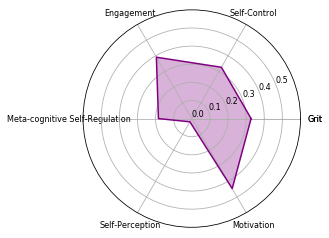

In [29]:
#Visualizing the three personas!

from math import pi

categories = ['Grit', 'Self-Control', 'Engagement', 'Meta-cognitive Self-Regulation', 'Self-Perception', 'Motivation']
N = len(categories)

angles0 = [(n / float(N))*2*pi for n in range(N)]

Learners['Persona1'] += Learners['Persona1'][:1]    # link tail with head
angles0 += angles0[:1]    # link tail with head
categories += categories[:1]    # link tail with head

plt.polar(angles0, Learners['Persona1'], 'purple')
# color the area inside
plt.tick_params(labelsize=8)
plt.fill(angles0, Learners['Persona1'], 'purple', alpha=0.3)
plt.xticks(angles0, categories)
axes = plt.gca()
axes.set_ylim(0,0.6)
axes.set_yticks(np.arange(0,0.6,0.1))


plt.show()

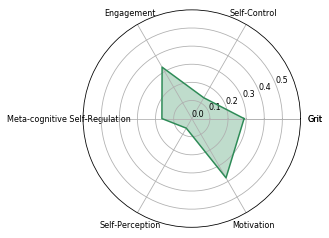

In [30]:
Learners['Persona2'] += Learners['Persona2'][:1]    # link tail with head

plt.polar(angles0, Learners['Persona2'], 'seagreen')
# color the area inside
plt.tick_params(labelsize=8)
plt.fill(angles0, Learners['Persona2'], 'seagreen', alpha=0.3)
plt.xticks(angles0, categories)
axes = plt.gca()
axes.set_ylim(0,0.6)
axes.set_yticks(np.arange(0,0.6,0.1))

plt.show()

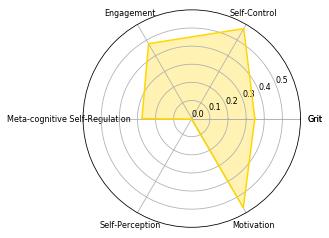

In [31]:
Learners['Persona3'] += Learners['Persona3'][:1]    # link tail with head

plt.polar(angles0, Learners['Persona3'], 'gold')
# color the area inside
plt.tick_params(labelsize=8)
plt.fill(angles0, Learners['Persona3'], 'gold', alpha=0.3)
plt.xticks(angles0, categories)
axes = plt.gca()
axes.set_ylim(0,0.6)
axes.set_yticks(np.arange(0,0.6,0.1))

plt.show()